In [1]:
import sys
sys.path.append('../..')

In [2]:
import numpy

def Dx(image: numpy.ndarray) -> numpy.ndarray:

    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))

    image_derivated[:, 1:nb_cols] = \
        image[:, 1:nb_cols] - image[:, 0:nb_cols-1]

    image_derivated[:, 0] = image[:, 0] - image[:, nb_cols-1]

    return image_derivated

def Dy(image: numpy.ndarray) -> numpy.ndarray:
    
    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))
    
    image_derivated[1:nb_rows, :] = \
        image[1:nb_rows, :] - image[0:nb_rows-1, :]

    image_derivated[0, :] = image[0, :] - image[nb_rows-1, :]

    return image_derivated

def Dxt(image: numpy.ndarray) -> numpy.ndarray:

    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))
    
    image_derivated[:, 0:nb_cols-1] = \
        image[:, 0:nb_cols-1] - image[:, 1:nb_cols]

    image_derivated[:, nb_cols-1] = image[:, nb_cols-1] - image[:, 0]

    return image_derivated


def Dyt(image: numpy.ndarray) -> numpy.ndarray:
    
    nb_rows, nb_cols = numpy.shape(image)
    image_derivated = numpy.zeros(shape=(nb_rows, nb_cols))
    
    image_derivated[0:nb_rows-1, :] = \
        image[0:nb_rows-1, :] - image[1:nb_rows, :]

    image_derivated[nb_rows-1, :] = image[nb_rows-1, :] - image[0, :]

    return image_derivated

def shrink2(x, y, lamda):

    

    # s = numpy.sqrt(x*numpy.conj(x)+y*numpy.conj(y))

    # # tmp = numpy.array([x, y])
    # # tmp2 = tmp**2
    # # tmp3 = numpy.sqrt(numpy.sum(tmp2, axis=0))
    # # print((tmp3 == s).all())

    # ss = s-lamda
    # ss = ss*(ss>0)

    # s=s+lamda
    # ss = ss / s

    # xs=ss*x
    # ys=ss*y

    s = numpy.sqrt(x**2+y**2)
    xs = numpy.where(s > lamda, (s-lamda)/s, 0)*x
    ys = numpy.where(s > lamda, (s-lamda)/s, 0)*y

    # print((s_copy==s2).all(), (xs==xs2).all(), (ys==ys2).all())

    return xs, ys

def multidimensional_soft(d: numpy.ndarray, lamda: float):
    s = numpy.sqrt(numpy.sum(d**2, axis=0))
    ss = numpy.where(s > lamda, (s-lamda)/s, 0)
    output = numpy.array([ss*d[i] for i in range(0, d.shape[0])])
    return output


## CMST_SegMain

In [3]:
import matplotlib.pyplot
import lasp.noise
import lasp.io

Img_nonoised = numpy.array(
    matplotlib.pyplot.imread('Boats.bmp'),
    dtype=numpy.double
)
Img = lasp.noise.awgn(
    Img_nonoised,
    snr=1
)

Img = Img - numpy.min(Img)
Img = Img / numpy.max(Img)

LAMBDA = 3
MU = 1
SIGMA = 2

import pathlib

path = pathlib.Path('PyVsMat/CMST_Seg')
lasp.io.save(Img, path / 'input.png')




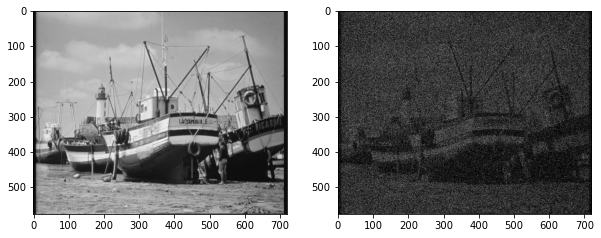

In [4]:
figure = matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.imshow(Img_nonoised, cmap='gray')
matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.imshow(Img, cmap='gray')

In [5]:
import numpy
import numpy.linalg

nb_rows, nb_cols = Img.shape
# INitialization
u = Img 
wx=numpy.zeros_like(Img)
wy=numpy.zeros_like(Img)
bx=numpy.zeros_like(Img)
by=numpy.zeros_like(Img)

#Build kernel
uker = numpy.zeros_like(Img)
uker[0, 0] = 4
uker[0, 1] = -1
uker[1, 0] = -1
uker[nb_rows-1, 0] = -1
uker[0, nb_cols-1] = -1


uker = LAMBDA+(MU+SIGMA)*numpy.fft.fft2(uker)

for i in range(0, 300):

    rhs = LAMBDA * Img + SIGMA*Dxt(wx-bx)+SIGMA*Dyt(wy-by)

    u0=numpy.copy(u)
    
    u = numpy.real(numpy.fft.ifft2(numpy.fft.fft2(rhs) / uker))

    err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')

    if i%10 == 0:
        print('Iterations: {} ! \t error is: {}'.format(i, err))

    if err < 10**(-4):
        break
    
    temp1 = Dx(u)+bx
    temp2 = Dy(u)+by

    wx, wy = shrink2(temp1, temp2, 1/SIGMA)
    # wx2, wy2 = multidimensional_shrink(
    #     numpy.array([temp1, temp2]), 
    #     1/SIGMA
    # )
    # print('wx == wx2 : {}\twy == wy2 : {}'.format((wx==wx2).all(), (wy==wy2).all()))

    bx=bx+Dx(u)-wx
    by=by+Dy(u)-wy

min_u = numpy.min(u)
max_u = numpy.max(u)
u = (u-min_u) / (max_u-min_u)



Iterations: 0 ! 	 error is: 0.5824166735338949
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
Iterations: 10 ! 	 error is: 0.0052276365853778555
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
Iterations: 20 ! 	 error is: 0.002231756070414873
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx == wx2 : True	wy == wy2 : True
wx

In [6]:
# Iterations: 0 ! 	 error is: 0.5828313907471018
# Iterations: 10 ! 	 error is: 0.005257127532810547
# Iterations: 20 ! 	 error is: 0.0022402374579070534
# Iterations: 30 ! 	 error is: 0.001427597339474172
# Iterations: 40 ! 	 error is: 0.0010443412784702545
# Iterations: 50 ! 	 error is: 0.0008218277793147644
# Iterations: 60 ! 	 error is: 0.0006542678577254054
# Iterations: 70 ! 	 error is: 0.0005380836339196822
# Iterations: 80 ! 	 error is: 0.00045492039456488894
# Iterations: 90 ! 	 error is: 0.0003833287257510178
# Iterations: 100 ! 	 error is: 0.0003355186870833229
# Iterations: 110 ! 	 error is: 0.00029070078002392297
# Iterations: 120 ! 	 error is: 0.0002558196848591491
# Iterations: 130 ! 	 error is: 0.0002283693000784214
# Iterations: 140 ! 	 error is: 0.0002037170037701887
# Iterations: 150 ! 	 error is: 0.00018508452121611946
# Iterations: 160 ! 	 error is: 0.00016736074381580658
# Iterations: 170 ! 	 error is: 0.0001525775499642868
# Iterations: 180 ! 	 error is: 0.00014040694993613847
# Iterations: 190 ! 	 error is: 0.0001292679379999406
# Iterations: 200 ! 	 error is: 0.00012164136027553352
# Iterations: 210 ! 	 error is: 0.00011176691636316504
# Iterations: 220 ! 	 error is: 0.00010517831878981639

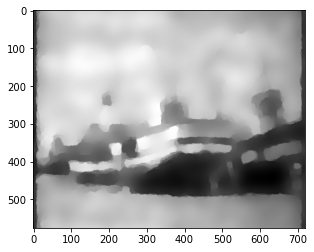

In [7]:
matplotlib.pyplot.imshow(numpy.real(u), cmap='gray')
lasp.io.save(u, path / 'output.png')

In [8]:
import scipy.io
a = scipy.io.matlab.loadmat('matlab_res/output_noised.mat')
mat_res = numpy.array(a['uu'])

numpy.max(numpy.abs(mat_res-u))
numpy.min(numpy.abs(mat_res-u))

3.219187633130005e-08

In [9]:
import lasp.metrics
lasp.metrics.mean_squared_error(mat_res, u)

0.001431652389763406

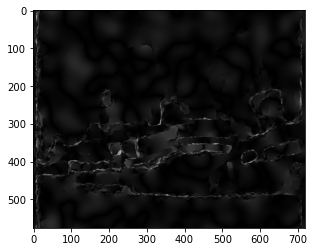

In [10]:
matplotlib.pyplot.imshow(numpy.abs(mat_res-u), cmap='gray')